In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys; sys.version

'3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) \n[GCC 9.4.0]'

In [22]:
from cbf_opt import asif, cbf, dynamics
from cbf_hjr import cbf as cbf_hjr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are
import hj_reachability as hj

In [23]:
# TODO: See whether we can just import this from a plotting_suite
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [24]:
class InvPendulum(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 2
        params['control_dims'] = 1  # TODO: How to do this correctly?
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state, time=None):
        return np.array([state[1], np.sin(state[0])])

    def control_matrix(self, state, time=None):
        return np.expand_dims(np.array([0, 1]), axis=-1)

    def state_jacobian(self, state, control, time=None):
        return np.array([[0, 1], [np.cos(state[0]), 0]])

In [25]:
class InvPendulumCBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)
        self.delta = params["delta"]

    def vf_dt_partial(self, state, time):
        return np.atleast_1d(0.)
        
    def vf(self, state, time=None):
        return np.minimum(1 - state[0] ** 2, 2 - state[1] ** 2)    

    def _grad_vf(self, state, time=None):
        if 1 - state[0] ** 2 < 2 - state[1] ** 2:
            return np.array([-2 * state[0], 0])
        else:
            return np.array([0, -2 * state[1]])


class InvPendulumImplicitCBF(cbf.ControlAffineImplicitCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)
        self.delta = params["delta"]
        self.backup_vf_scalar = kwargs.get('backup_vf_scalar', 100)

    def backup_vf(self, state, time=None):
        return self.backup_vf_scalar * np.minimum((np.pi / 12) ** 2 - state[0] ** 2, self.delta ** 2 - state[1] ** 2)

    def safety_vf(self, state, time=None):
        return np.minimum(1 - state[0] ** 2, 2 - state[1] ** 2)
    
    def _grad_safety_vf(self, state, time=None):
        if 1 - state[0] ** 2 < 2 - state[1] ** 2:
            return np.array([-2 * state[0], 0])
        else:
            return np.array([0, -2 * state[1]])
    
    def _grad_backup_vf(self, state, time=None):
        return self.backup_vf_scalar * self._grad_safety_vf(state, time)

In [26]:
class InvPendulumBackupController(cbf.BackupController):

    def __init__(self, dynamics, T_backup, **kwargs):
        super().__init__(dynamics, T_backup, **kwargs)
        self.lqr_term = kwargs.get('F', np.zeros((self.dynamics.n_dims, self.dynamics.control_dims)))

    def policy(self, x, t):
        action = -np.atleast_1d(self.lqr_term @ x)
        if self.umin is not None:
            action = np.maximum(action, self.umin)
        if self.umax is not None:
            action = np.minimum(action, self.umax)
        return action
    
    def grad_policy(self, x, t):
        return -self.lqr_term

In [27]:
inv_pend = InvPendulum({'dt': 0.01})
inv_pend_cbf = InvPendulumImplicitCBF(inv_pend, params={'delta': 0.1})

In [28]:
A = inv_pend.state_jacobian(np.array([0, 0]), np.array([0]))
B = inv_pend.control_jacobian(np.array([0, 0]), np.array([0]))
Q = np.eye(2); R = 1e4 * np.eye(1)

P = solve_continuous_are(A, B, Q, R)
F = np.linalg.inv(R) @ B.T @ P

backup_controller = InvPendulumBackupController(inv_pend, T_backup=3.5, F=F, umin=-3, umax=3)

In [29]:
inv_pend_cbf.backup_controller = backup_controller

In [30]:
nominal_policy = lambda x, t: np.atleast_1d(2.)

In [31]:
trade_off_filter = asif.TradeoffFilter(inv_pend, inv_pend_cbf, backup_controller, nominal_policy=nominal_policy, beta = 30.)

## Calculating trajectories

In [32]:
x0 = np.array([0., 0.])
states = [x0]
control = []

ts = np.arange(0, 5, 0.01)

x = x0

for t in ts:  
    input_nom = nominal_policy(x, t)
    x = inv_pend.step(x, input_nom)
    states.append(x)
    control.append(input_nom)

states = np.array(states)

In [33]:
x0 = np.array([0., 0.])
states_filt = [x0]
control_filt = []

ts = np.arange(0, 5, 0.01)

x = x0

for i, t in enumerate(ts):  
    input_nom = trade_off_filter(x, time=t)
    x = inv_pend.step(x, input_nom)
    states_filt.append(x)
    control_filt.append(input_nom)

states_filt = np.array(states_filt)

## Plotting some garbage

/tmp/ipykernel_26506/1866057638.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


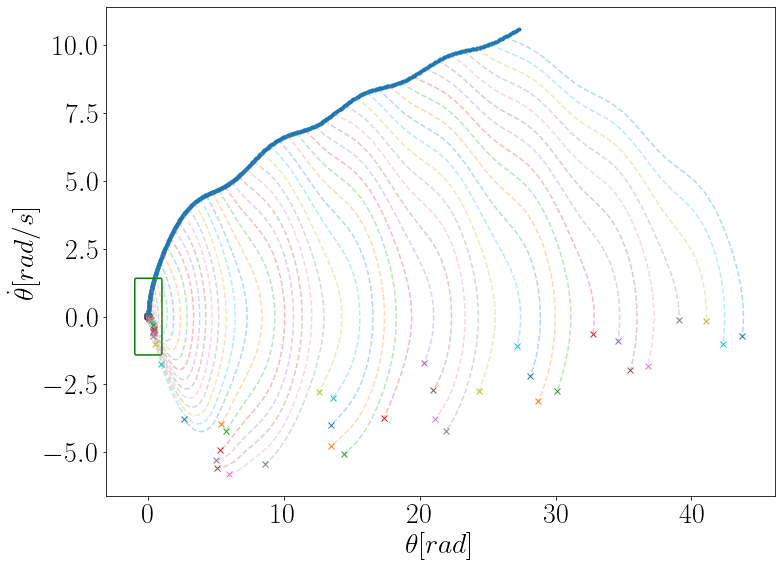

In [34]:
XX1, XX2 = np.meshgrid(np.linspace(-np.pi, np.pi, 100), np.linspace(-np.pi, np.pi, 100))
ZZ = inv_pend_cbf.backup_vf(np.array([XX1.ravel(), XX2.ravel()]))
ZZ2 = inv_pend_cbf.safety_vf(np.array([XX1.ravel(), XX2.ravel()]))

fig, ax = plt.subplots(figsize=(12,9))

ax.contour(XX1, XX2, ZZ.reshape(XX1.shape[0], XX1.shape[1]), levels=[0])
ax.plot(states[:, 0], states[:, 1], '.')

ax.contour(XX1, XX2, ZZ2.reshape(XX1.shape[0], XX1.shape[1]), levels=[0], colors='g')

ax.set_xlabel(r"$\theta[rad]$")
ax.set_ylabel(r"$\dot{\theta}[rad/s]$")


for i in range(states.shape[0] // 10):
    x0 = states[10 * i].copy()
    states_temp, _ = backup_controller.rollout_backup(x0, t0=0)
    p1 = ax.plot(states_temp[:,0], states_temp[:,1], '--', alpha=0.3)
    ax.plot(states_temp[-1,0], states_temp[-1,1], 'x', color=p1[0].get_color())
fig.show()

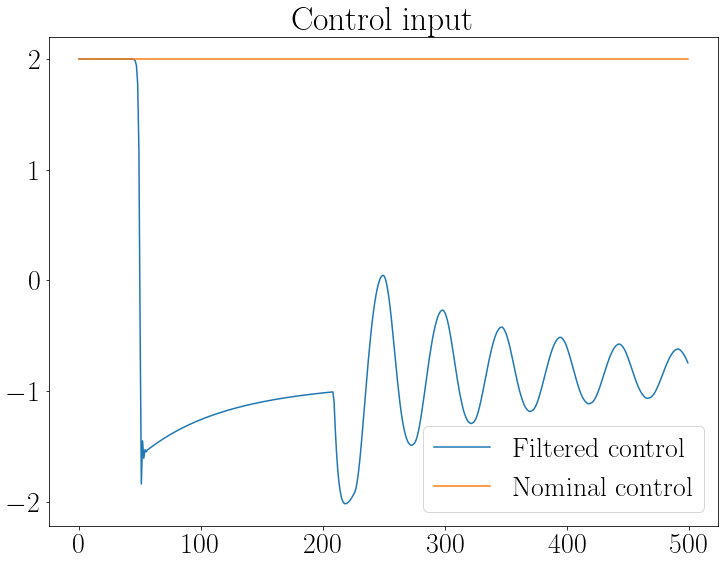

In [35]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(control_filt, label='Filtered control')
ax.plot(control, label='Nominal control')
ax.set_title('Control input')
ax.legend()

In [36]:
low_bound = np.array([-np.pi, -np.pi])
high_bound = np.array([np.pi, np.pi])
nbr_pts = (100, 100)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)

inv_pend_tabular_cbf = cbf_hjr.TabularCBF(inv_pend, grid)

In [37]:
inv_pend_tabular_cbf.tabularize_cbf(inv_pend_cbf)

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Text(0.5, 0.98, 'Rotary inverted pendulum (2D)')

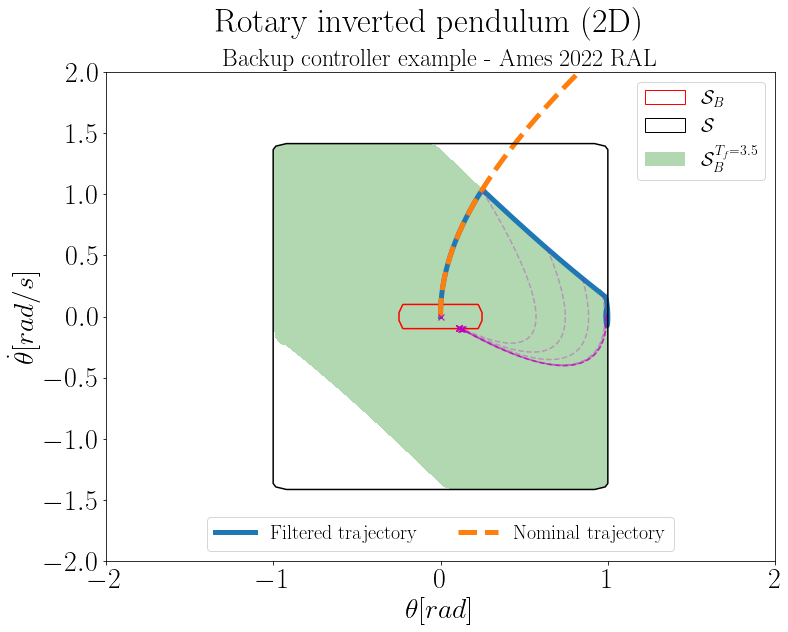

In [38]:
fig, ax = plt.subplots(figsize=(12,9))
cs = ax.contour(XX1, XX2, ZZ.reshape(XX1.shape[0], XX1.shape[1]), levels=[0], colors='r')
proxy = []
proxy += [plt.Rectangle((0,0),1,1,ec = 'r', fc='white') 
         for pc in cs.collections]

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.plot(states_filt[:, 0], states_filt[:, 1], linewidth=5, label="Filtered trajectory")
ax.plot(states[:, 0], states[:, 1], "--", linewidth=5, label="Nominal trajectory")

leg = ax.legend(loc="lower center", prop={"size": 20}, ncol=2)


for i in range(states_filt.shape[0] // 50):
    states_backedup, _ = backup_controller.rollout_backup(states_filt[50 * i])
    ax.plot(states_backedup[:,0], states_backedup[:,1], '--', alpha=0.3, color='m')
    ax.plot(states_backedup[-1,0], states_backedup[-1,1], 'x', color='m')

cs = ax.contour(XX1, XX2, ZZ2.reshape(XX1.shape[0], XX1.shape[1]), levels=[0], colors='k')
proxy += [plt.Rectangle((0,0),1,1,ec = 'k', fc='white') 
         for pc in cs.collections]


cs = ax.contourf(XX1, XX2, inv_pend_tabular_cbf.vf_table.T, levels=[0.01, 2], alpha=0.3, colors='g')
proxy += [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
         for pc in cs.collections]


ax.set_ylabel(r"$\dot{\theta}[rad/s]$")
ax.set_xlabel(r"$\theta[rad]$")
ax.legend(proxy, ["$\mathcal{S}_B$", "$\mathcal{S}$", "$\mathcal{S}_B^{T_f=3.5}$"], prop={'size': 20})

ax.add_artist(leg)

ax.set_title("Backup controller example - Ames 2022 RAL", fontsize=24)
fig.suptitle("Rotary inverted pendulum (2D)")